In [6]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_colwidth=1000
pd.options.display.float_format = '{:.3f}'.format

In [7]:
import os

directory_path = "./litgpt_rope_H100"  # Replace with the actual path

files = None
try:
    files = os.listdir(directory_path)
    #print("Files in directory:", files)
except FileNotFoundError:
    print(f"Error: Directory '{directory_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

bench_list = [os.path.splitext(file)[0] for file in files]
#print(bench_list)

In [8]:
dfs = {name: pd.read_csv(directory_path + "/" + name + ".csv") for name in bench_list}

pivot_dfs = {}
for name,df in dfs.items():
    pivot_dfs[name] = df.pivot(index=["Model", "Batch", "Seq-Len"], columns=["Executor"], values=["Fwd-K-Time(ms)", "Fwd-K-Spdup", "Bwd-K-Time(ms)", "Bwd-K-Spdup", "K-Time(ms)", "K-Spdup", "Wall-Time(ms)", "Wall-Spdup", "Overhead(ms)"])

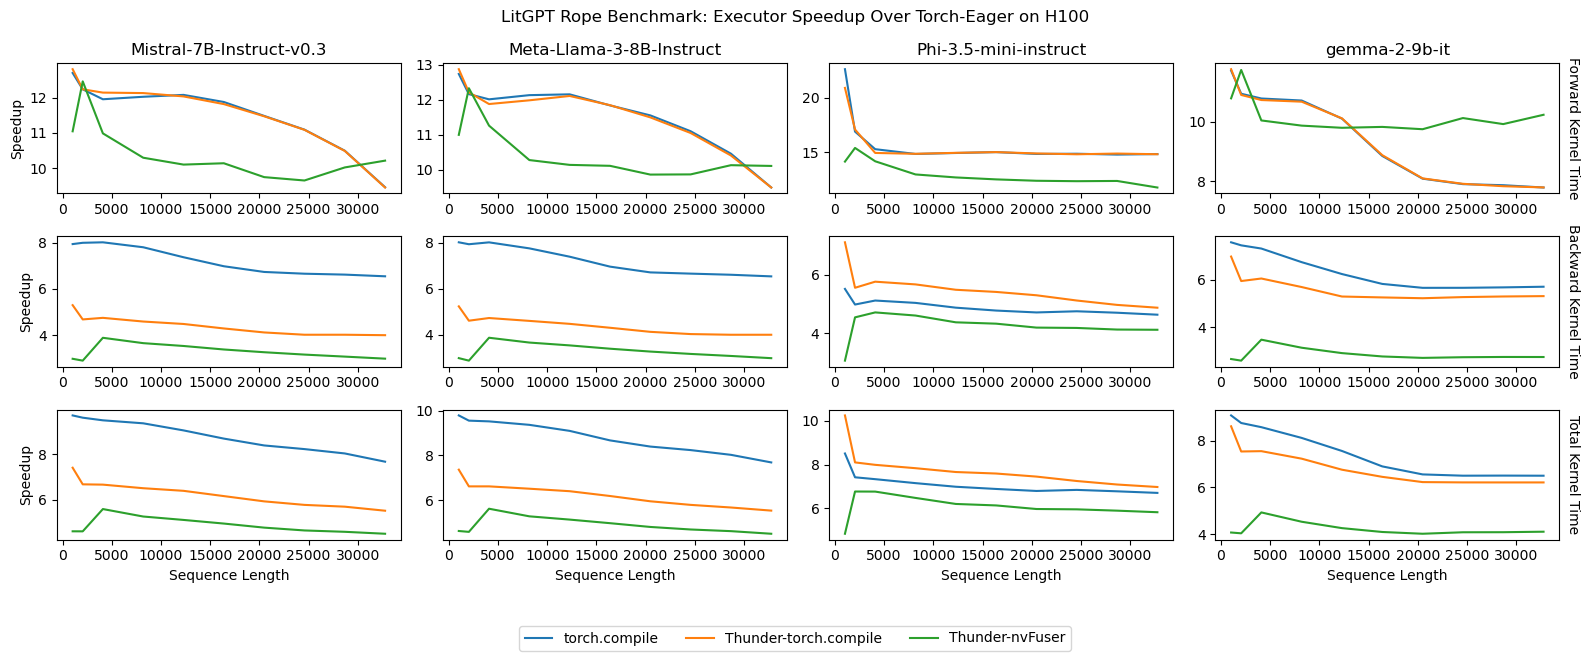

In [9]:
num_plots = len(pivot_dfs)
executor_list = ["torch.compile", "Thunder-torch.compile", "Thunder-nvFuser"]
fig, axes = plt.subplots(nrows=3, ncols=num_plots, figsize=(4*num_plots, 6))
for idx,name in enumerate(bench_list):
    pivot_dfs[name]['Fwd-K-Spdup'].reset_index().plot(ax=axes[0,idx], x="Seq-Len", y=executor_list)
    axes[0, idx].legend().remove()
    axes[0, idx].set_title(name)
    axes[0, idx].set_xlabel("")
    if idx == 0:
        axes[0, idx].set_ylabel("Speedup")
    if idx == (num_plots - 1):
        axes[0, idx].yaxis.set_label_position("right")
        axes[0, idx].set_ylabel('Forward Kernel Time', rotation=270, labelpad=15)
    pivot_dfs[name]['Bwd-K-Spdup'].reset_index().plot(ax=axes[1,idx], x="Seq-Len", y=executor_list)
    axes[1, idx].legend().remove()
    axes[1, idx].set_xlabel("")
    if idx == 0:
        axes[1, idx].set_ylabel("Speedup")
    if idx == (num_plots - 1):
        axes[1, idx].yaxis.set_label_position("right")
        axes[1, idx].set_ylabel('Backward Kernel Time', rotation=270, labelpad=15)
    pivot_dfs[name]['K-Spdup'].reset_index().plot(ax=axes[2,idx], x="Seq-Len", y=executor_list)
    axes[2, idx].legend().remove()
    axes[2, idx].set_xlabel("Sequence Length")
    if idx == 0:
        axes[2, idx].set_ylabel("Speedup")
    if idx == (num_plots - 1):
        axes[2, idx].yaxis.set_label_position("right")
        axes[2, idx].set_ylabel('Total Kernel Time', rotation=270, labelpad=15)
fig.legend(labels=executor_list, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.1))
fig.suptitle("LitGPT Rope Benchmark: Executor Speedup Over Torch-Eager on H100")
plt.tight_layout()
fig.savefig('litgpt_rope_executor_h100s.png', dpi=300, bbox_inches='tight')
plt.show()

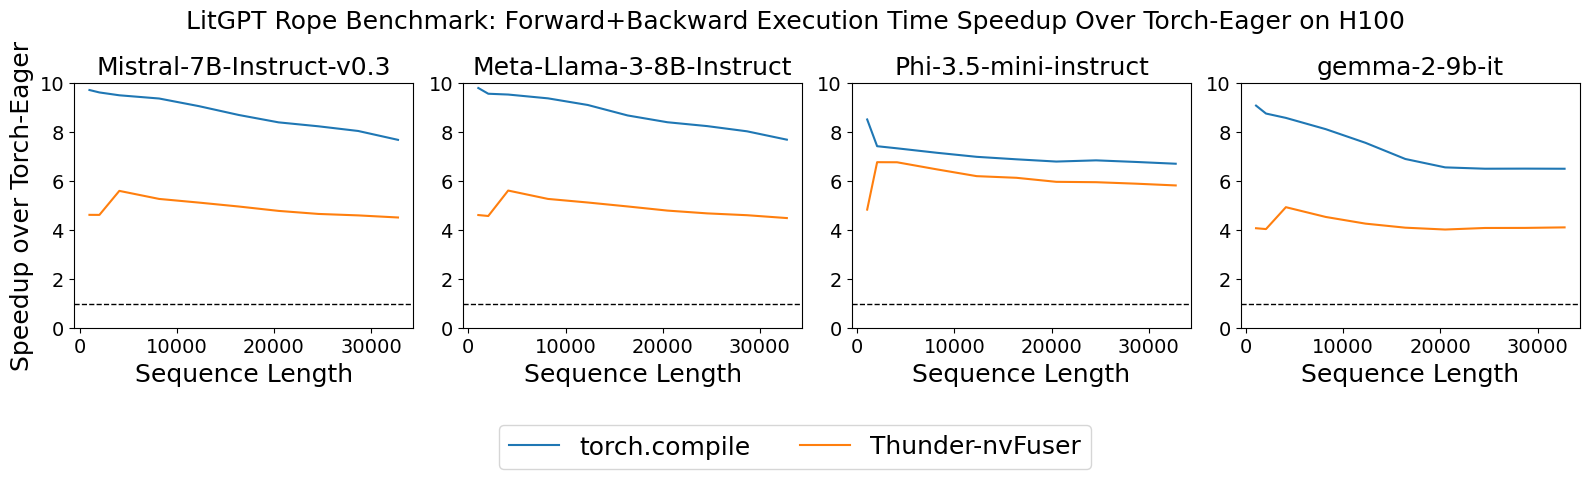

In [10]:
executor_list = ["torch.compile", "Thunder-nvFuser"]
fsize = 18
font = {'fontsize': fsize}
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(4*num_plots, 4))
for idx,name in enumerate(bench_list):
    pivot_dfs[name]['K-Spdup'].reset_index().plot(ax=axes[idx], x="Seq-Len", y=executor_list)
    axes[idx].legend().remove()
    axes[idx].set_title(name, fontdict=font)
    axes[idx].set_xlabel("")
    if idx == 0:
        axes[idx].set_ylabel("Speedup over Torch-Eager", fontdict=font)
    axes[idx].set_xlabel("Sequence Length", fontdict=font)
    axes[idx].set_ylim(bottom=0, top=10)
    axes[idx].axhline(y=1, color='black', linestyle='--', linewidth=1)
    axes[idx].tick_params(axis='x', labelsize=14)
    axes[idx].tick_params(axis='y', labelsize=14)
fig.legend(labels=executor_list, loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.2), fontsize=fsize)
fig.suptitle("LitGPT Rope Benchmark: Forward+Backward Execution Time Speedup Over Torch-Eager on H100", fontsize=fsize)
plt.tight_layout()
fig.savefig('litgpt_rope_executors_h100_top5.png', dpi=300, bbox_inches='tight')
plt.show()